<a href="https://colab.research.google.com/github/mmrepos/Chest_X-Ray_Images_Preprocessing/blob/main/Chest_X_Ray_Images_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!pip install kaggledatasets
#!pip install tensorflow
import cv2
import os
import glob
import re
import os
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly
import plotly.express as ex
import plotly.graph_objs as go
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.9.2


In [ ]:
#List the contents of a Kaggle Dataset
for dirname, _, filenames in os.walk('/content/drive/MyDrive/chest-x-ray-images-preprocessing'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Use KaggleDatasets().get_gcs_path() to retrieve public GCS paths from a public Kaggle dataset
#GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [16]:
# Loading the Dataset
train_data = glob.glob(f"/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/**/*.jpeg")
test_data = glob.glob(f"/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/**/*.jpeg")
val_data = glob.glob(f"/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/val/**/*.jpeg")

# Looking at the training, testing and validation data numbers
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 1869 images
Testing Set has: 624 images
Validation Set has: 16 images


In [17]:
# Get the class labels in Train, Test and Val
DIR = "/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/"
data = ["train", "test", "val"]

pneumonia_train = []
pneumonia_test = []
pneumonia_val = []
normal_train = []
normal_test = []
normal_val = []

for s in data:
    if s=="train":
        path = os.path.join(DIR, s)
        norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
        pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
        normal_train.extend(norm)
        pneumonia_train.extend(pneu)
    elif s=="test":
        path = os.path.join(DIR, s)
        norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
        pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
        normal_test.extend(norm)
        pneumonia_test.extend(pneu)
    else:
        path = os.path.join(DIR, s)
        norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
        pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
        normal_val.extend(norm)
        pneumonia_val.extend(pneu)

print("Train Set ----->")
print(f"Total Pneumonia Images: {len(pneumonia_train)}")
print(f"Total Normal Images: {len(normal_train)}")

print("Test Set ----->")
print(f"Total Pneumonia Images: {len(pneumonia_test)}")
print(f"Total Normal Images: {len(normal_test)}")

print("Val Set ----->")
print(f"Total Pneumonia Images: {len(pneumonia_val)}")
print(f"Total Normal Images: {len(normal_val)}")

Train Set ----->
Total Pneumonia Images: 528
Total Normal Images: 1341
Test Set ----->
Total Pneumonia Images: 390
Total Normal Images: 234
Val Set ----->
Total Pneumonia Images: 8
Total Normal Images: 8


In [18]:
plot={"train":[pneumonia_train,normal_train],"test":[pneumonia_test,normal_test],"val":[pneumonia_val,normal_val]}

In [53]:
from plotly.subplots import make_subplots
#Create a 1x2 subplot
fig = make_subplots(rows=1, cols=3,specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])
# create empty figure trace
figure_traces = []
# Get express fig broken down as traces and add the traces to the proper plot within in the subplot
i=1
for p in plot:
    fig.add_trace(go.Pie(labels=["Normal","Pneumonia"],
            values=[len(plot[p][0]),len(plot[p][1])],
            marker={'colors':['orange','darkblue']},
            hole=0.2),
            row=1,col=i)
    i+=1
    fig.update_layout(template="plotly_dark",title="Normal vs Pneumonia")
fig.show()

In [20]:
# appending the validation files and creating a new split which would resembes the standard 80:20 division
file_names = tf.io.gfile.glob(str(f'/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/**/*.jpeg'))
file_names.extend(tf.io.gfile.glob(str(f'/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/val/**/*.jpeg')))

train_file_names, val_file_names = train_test_split(file_names, test_size=0.2)

In [21]:
# healthy/normal chest X-rays vs pneumonia chest X-rays
NORMAL_COUNT = len([filename for filename in train_file_names if "NORMAL" in filename])
print("Normal images count in training set: " + str(NORMAL_COUNT))

PNEUMONIA_COUNT = len([filename for filename in train_file_names if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(PNEUMONIA_COUNT))

Normal images count in training set: 1071
Pneumonia images count in training set: 437


In [22]:
# more images that are classified as normal than pneumonia indicating an imbalance in the data.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_file_names)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_file_names)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/NORMAL/NORMAL2-IM-1020-0001-0002.jpeg'
b'/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/NORMAL/NORMAL2-IM-1256-0001.jpeg'
b'/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/NORMAL/NORMAL2-IM-0695-0001.jpeg'
b'/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/NORMAL/NORMAL2-IM-0547-0001.jpeg'
b'/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/NORMAL/NORMAL2-IM-1191-0001.jpeg'


In [23]:
# Checking how many images are in the training dataset vs images in the validation set to see if ratio of images is 80:20.
TRAIN_IMAGE_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMAGE_COUNT))

VAL_IMAGE_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMAGE_COUNT))

Training images count: 1508
Validating images count: 377


In [24]:
# Two Labels for the images
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str("/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [25]:
# mapping each filename to the corresponding (image, label) pair.
# 1 or True indicating pneumonia and 0 or False indicating normal
def get_label(file_path):
    # converting path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # second to last for the class-directory
    return parts[-2] == "PNEUMONIA"

In [26]:
# scaling down
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use 'convert_image_dtype' to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [27]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [28]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
# visualizing shape of an (image, label) pair.
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [29]:
test_list_ds = tf.data.Dataset.list_files(str('/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [30]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # small dataset, only loaded once, and kept in memory.
    # use '.cache(filename)' to cache preprocessing work for datasets that
    # doesn't fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # decouple the time when data is produced from the time when data is consumed
    # .prefetch() overlaps data preprocessing and model execution while training.
    # Allows for the dataset to fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [31]:
# Calling the next batch iteration of the training data.
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [34]:
# method to show images that are in the batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(0, len(image_batch)):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

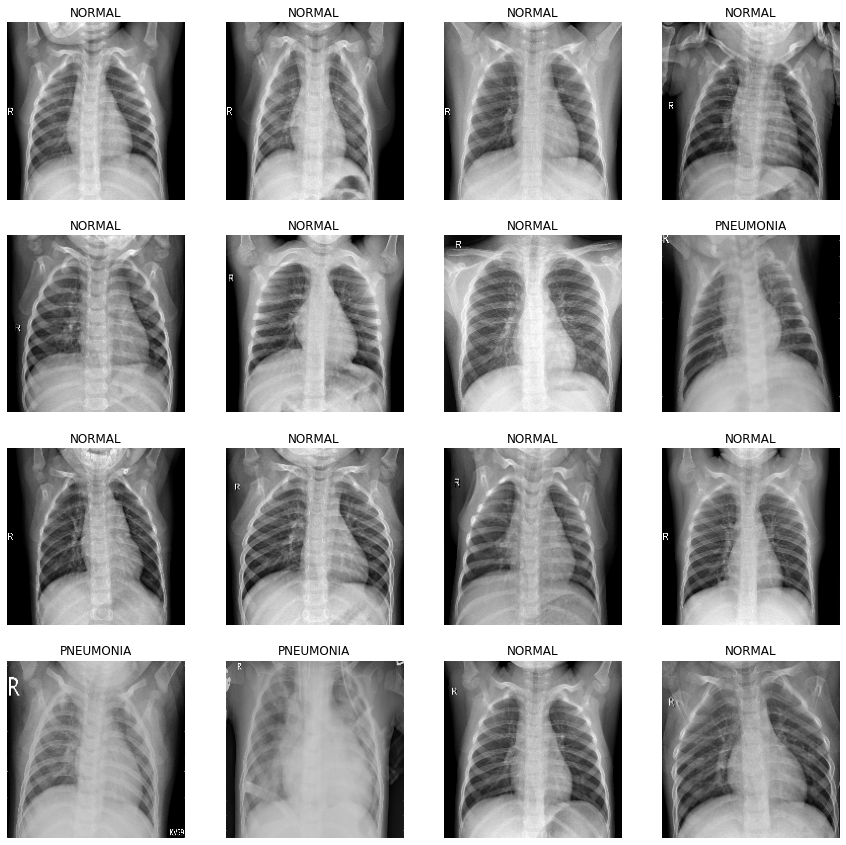

In [35]:
# calling numpy function on batches to return tensor in numpy array form
show_batch(image_batch.numpy(), label_batch.numpy())

In [36]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [37]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [38]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [45]:
# correcting the data imbalanced
initial_bias = np.log([PNEUMONIA_COUNT/NORMAL_COUNT])
initial_bias

array([-0.89641488])

In [46]:
weight_for_0 = (1 / NORMAL_COUNT)*(TRAIN_IMAGE_COUNT)/2.0 
weight_for_1 = (1 / PNEUMONIA_COUNT)*(TRAIN_IMAGE_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight class 0: {:.2f}'.format(weight_for_0))
print('Weight class 1: {:.2f}'.format(weight_for_1))
# weight for class 0 (Normal) is higher that the weight for class 1 (Pneumonia)

Weight class 0: 0.70
Weight class 1: 1.73


In [47]:
# Training the model
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [48]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMAGE_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMAGE_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
94/94 [==============================] - 106s 919ms/step - loss: 0.5234 - accuracy: 0.7414 - precision: 0.5354 - recall: 0.8142 - val_loss: 0.5801 - val_accuracy: 0.7337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
94/94 [==============================] - 74s 791ms/step - loss: 0.2939 - accuracy: 0.8684 - precision: 0.7177 - recall: 0.9016 - val_loss: 0.5797 - val_accuracy: 0.7337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
94/94 [==============================] - 73s 774ms/step - loss: 0.2415 - accuracy: 0.9009 - precision: 0.7786 - recall: 0.9197 - val_loss: 0.6128 - val_accuracy: 0.7364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
94/94 [==============================] - 71s 752ms/step - loss: 0.2075 - accuracy: 0.9195 - precision: 0.8158 - recall: 0.9307 - val_loss: 1.1990 - val_accuracy: 0.2636 - val_precision: 0.2636 - val_recall: 1.0000
Epoch 5/25
94/94 [==============================] - 71s 752ms/step - loss: 

In [49]:
# using Keras callbacks to further finetune our model.
# saving the best weights using checkpoint callback to avoid spending 
# time training next time when using the model
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [50]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [52]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMAGE_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMAGE_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_callbacks, early_stopping_callbacks, lr_scheduler]
)

Epoch 1/100
94/94 [==============================] - 74s 791ms/step - loss: 0.4566 - accuracy: 0.8191 - precision: 0.6571 - recall: 0.7867 - val_loss: 64.0250 - val_accuracy: 0.7418 - val_precision: 1.0000 - val_recall: 0.0104 - lr: 0.0100
Epoch 2/100
94/94 [==============================] - 71s 759ms/step - loss: 0.3265 - accuracy: 0.8664 - precision: 0.7224 - recall: 0.8736 - val_loss: 2.4489 - val_accuracy: 0.7880 - val_precision: 1.0000 - val_recall: 0.2041 - lr: 0.0089
Epoch 3/100
94/94 [==============================] - 71s 755ms/step - loss: 0.3316 - accuracy: 0.8703 - precision: 0.7304 - recall: 0.8761 - val_loss: 1.0639 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.0515 - lr: 0.0079
Epoch 4/100
94/94 [==============================] - 73s 774ms/step - loss: 0.2875 - accuracy: 0.8850 - precision: 0.7481 - recall: 0.9108 - val_loss: 0.1661 - val_accuracy: 0.9266 - val_precision: 0.9733 - val_recall: 0.7449 - lr: 0.0071
Epoch 5/100
94/94 [========================

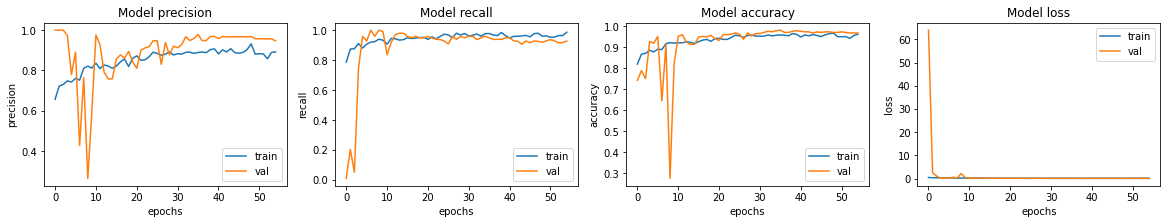

In [54]:
# visualizing model performance i.e., accuracy and loss values for the second round of training
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])